In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize


In [3]:
from datetime import datetime

In [4]:
regime_df = pd.read_csv('regime_prediction_RF_single_base_model.csv',index_col='Unnamed: 0', parse_dates=True)
stage1_features_df = pd.read_csv('stage02_data.csv', index_col='Unnamed: 0', parse_dates=True)
factor_returns_df = pd.read_csv('final_df.csv', index_col='Date', parse_dates=True)

print("shape:")
print(f"Regime predict: {regime_df.shape}")
print(f"Stage1: {stage1_features_df.shape}") 
print(f"factor return: {factor_returns_df.shape}")

# 1. data structure
print("\nRegime column:")
print(regime_df.columns.tolist())
print("\nStage1 feature column:")
print(stage1_features_df.columns.tolist())
print("\nfactor return column:")
print(factor_returns_df.columns.tolist())

shape:
Regime predict: (307, 1)
Stage1: (308, 12)
factor return: (308, 7)

Regime column:
['regime_pred']

Stage1 feature column:
['financial_turbulence', 'nfc_risk', 'nfc_credit', 'nfc_leverage', 'TR CAPE', 'effr', 't3m effr spread', 'sp_3m_drawdown', 'regime', 'real_gdp_growth_monthly', 'cpi_1y', 'cpi_10y']

factor return column:
['Value', 'Growth', 'Momentum', 'Quality', 'Small_Cap', 'Low_Vol', 'RF']


In [5]:
def prepare_stage2_data(regime_df, stage1_features_df, factor_returns_df):
    """
    prepare all data need to use for stage 2
    """
    common_dates = regime_df.index.intersection(stage1_features_df.index).intersection(factor_returns_df.index)
    
    merged_data = pd.DataFrame(index=common_dates)
    
    merged_data['True_Regime'] = stage1_features_df.loc[common_dates, 'regime'] 
    merged_data['True_Regime'] = merged_data['True_Regime'].replace(2, 1)
    merged_data['Predicted_Regime'] = regime_df.loc[common_dates, 'regime_pred'] 
    
    feature_columns = ['financial_turbulence', 'nfc_risk', 'nfc_credit', 'nfc_leverage', 'TR CAPE', 'effr', 't3m effr spread', 'sp_3m_drawdown', 'real_gdp_growth_monthly', 'cpi_1y', 'cpi_10y']
    for col in feature_columns:
        merged_data[col] = stage1_features_df.loc[common_dates, col]
    
    factor_columns = ['Value', 'Growth', 'Momentum', 'Quality', 'Small_Cap', 'Low_Vol']
    for col in factor_columns:
        merged_data[col] = factor_returns_df.loc[common_dates, col]
    
    print(f"merged data shape: {merged_data.shape}")
    print(f"time range: {merged_data.index.min()} to {merged_data.index.max()}")
    print(f"market regime - true:")
    print(merged_data['True_Regime'].value_counts().sort_index())
    print(f"market regime - predict:")
    print(merged_data['Predicted_Regime'].value_counts().sort_index())
    
    return merged_data

full_data = prepare_stage2_data(regime_df, stage1_features_df, factor_returns_df)

merged data shape: (306, 19)
time range: 2000-03-01 00:00:00 to 2025-08-01 00:00:00
market regime - true:
True_Regime
0    193
1    113
Name: count, dtype: int64
market regime - predict:
Predicted_Regime
0    179
1    127
Name: count, dtype: int64


# rolling

## stage 2

In [6]:
class FactorPerformancePredictor:
    """
    Stage 2 (Expanding Rolling Version, Clean)
    Train RF models by TRUE regime each month,
    then predict this-month factor win probabilities using PREDICTED regime.
    """

    def __init__(self, factor_names):
        self.factor_names = factor_names

    def _create_factor_labels(self, factor_returns):
        """Label = 1 if factor is best this month"""
        valid = factor_returns[self.factor_names].dropna(how='all')
        best_factor = valid.idxmax(axis=1)
        labels = pd.DataFrame({
            f: (best_factor == f).astype(int).reindex(factor_returns.index).fillna(0)
            for f in self.factor_names
        }, index=factor_returns.index)
        return labels

    def _train_models_by_regime(self, X, y_labels, regimes):
        """Train regime-specific Random Forests"""
        models, scalers = {}, {}
        for regime in sorted(regimes.dropna().unique()):
            mask = regimes == regime
            X_reg, y_reg = X.loc[mask], y_labels.loc[mask]
            if X_reg.empty:
                continue

            # Handle missing values and scaling
            X_reg = X_reg.ffill().bfill()
            scaler = StandardScaler()
            X_scaled = pd.DataFrame(
                scaler.fit_transform(X_reg),
                columns=X_reg.columns,
                index=X_reg.index
            )
            scalers[regime] = scaler

            regime_models = {}
            for f in self.factor_names:
                y = y_reg[f].values
                if y.sum() == 0:
                    continue
                model = RandomForestClassifier(
                    n_estimators=200,
                    max_depth=8,
                    class_weight='balanced',
                    random_state=42
                )
                model.fit(X_scaled, y)
                regime_models[f] = model
            models[regime] = regime_models
        return models, scalers

    def _predict_one_month(self, X_single, regime_pred, models, scalers):
        """Predict probability vector for one month"""
        if regime_pred not in models:
            return {f: 1/len(self.factor_names) for f in self.factor_names}

        scaler = scalers[regime_pred]
        X_scaled = pd.DataFrame(
            scaler.transform(X_single),
            columns=X_single.columns,
            index=X_single.index
        )

        probs = {}
        for f in self.factor_names:
            if f in models[regime_pred]:
                probs[f] = models[regime_pred][f].predict_proba(X_scaled)[0, 1]
            else:
                probs[f] = 0.0

        s = sum(probs.values())
        return {k: v/s if s > 0 else 1/len(self.factor_names) for k, v in probs.items()}

    def expanding_predict(self, full_data, factor_cols, feature_cols, start_train_idx=60):
        """
        Expanding training each month, predict this-month winning factor.
        """
        factor_labels = self._create_factor_labels(full_data[factor_cols])
        records = []

        for t in range(start_train_idx, len(full_data)):
            train = full_data.iloc[:t]
            test_row = full_data.iloc[[t]]
            current_date = full_data.index[t]

            X_train = train[feature_cols]
            y_train = factor_labels.iloc[:t]
            true_regime = train['True_Regime']

            models, scalers = self._train_models_by_regime(X_train, y_train, true_regime)

            X_t = test_row[feature_cols]
            pred_regime = test_row['Predicted_Regime'].iloc[0]

            probs = self._predict_one_month(X_t, pred_regime, models, scalers)
            probs['Date'] = current_date
            probs['Predicted_Regime'] = pred_regime
            probs['True_Regime'] = test_row['True_Regime'].iloc[0]

            records.append(probs)

            if (t - start_train_idx) % 12 == 0:
                print(f"Trained up to {current_date.date()}")

        prob_df = pd.DataFrame(records).set_index('Date')
        prob_df.columns = [f"Prob_{c}" if c in self.factor_names else c for c in prob_df.columns]
        return prob_df

In [7]:
factor_cols = ['Value', 'Growth', 'Momentum', 'Quality', 'Small_Cap', 'Low_Vol']
feature_cols =['financial_turbulence', 'nfc_risk', 'nfc_credit', 'nfc_leverage', 
               'TR CAPE', 'effr', 't3m effr spread', 'sp_3m_drawdown', 'real_gdp_growth_monthly', 'cpi_1y', 'cpi_10y']

predictor = FactorPerformancePredictor(factor_cols)
rolling_probs = predictor.expanding_predict(full_data, factor_cols, feature_cols, start_train_idx=240)

Trained up to 2020-03-01
Trained up to 2021-03-01
Trained up to 2022-03-01
Trained up to 2023-03-01
Trained up to 2024-03-01
Trained up to 2025-03-01


In [9]:
def calculate_factor_accuracy(true_returns, rolling_probs, factor_cols):
    """
    Evaluate factor prediction accuracy from rolling_probs output
    Inputs:
        true_returns : full_data[factor_cols]
        rolling_probs : output from predictor.expanding_predict()
        factor_cols : list of factor names used in Stage2
    Output:
        dict of per-factor accuracy + predicted count
        float overall accuracy
    """

    results = {f: {"correct": 0, "predicted_count": 0} for f in factor_cols}
    total_correct = 0
    total_periods = len(rolling_probs)

    # iterate by date
    for dt in rolling_probs.index:
        pred_prob_row = rolling_probs.loc[dt]

        predicted_winner = pred_prob_row[[f"Prob_{f}" for f in factor_cols]].idxmax() # Predicted Winner
        predicted_winner = predicted_winner.replace("Prob_", "") 

        true_winner = true_returns.loc[dt].idxmax()

        results[predicted_winner]["predicted_count"] += 1

        # Compare
        if predicted_winner == true_winner:
            results[predicted_winner]["correct"] += 1
            total_correct += 1

    # compute accuracy per factor
    for f in factor_cols:
        pred_cnt = results[f]["predicted_count"]
        results[f]["accuracy"] = results[f]["correct"] / pred_cnt if pred_cnt > 0 else 0.0

    overall_accuracy = total_correct / total_periods if total_periods > 0 else 0.0

    return results, overall_accuracy


In [10]:
true_returns = full_data[factor_cols]

accuracy_results, overall_accuracy = calculate_factor_accuracy(
    true_returns=true_returns,
    rolling_probs=rolling_probs,
    factor_cols=factor_cols
)

In [20]:
# actual winning frequency (for reference / compare baseline)
actual_win_pct = {}
for f in factor_cols:
    actual_win_pct[f] = sum(true_returns.idxmax(axis=1) == f) / len(true_returns)


print("\n" + "="*60)
print("FACTOR PREDICTION ACCURACY (Stage 2)")
print("="*60)

print(f"\n{'Factor':<12} {'Accuracy':<10} {'Pred Count':<12} {'Actual Win %':<10}")
print("-"*60)

for f in factor_cols:
    acc = accuracy_results[f]['accuracy']
    pc = accuracy_results[f]['predicted_count']
    aw = actual_win_pct[f]
    print(f"{f:<12} {acc:>7.3f}      {pc:>6d}         {aw:>7.3f}")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Overall Accuracy:  {overall_accuracy:.3f}")
print(f"Random Baseline:   {1/len(factor_cols):.3f}")



FACTOR PREDICTION ACCURACY (Stage 2)

Factor       Accuracy   Pred Count   Actual Win %
------------------------------------------------------------
Value          0.444           9           0.118
Growth         0.406          32           0.363
Momentum       0.364          11           0.206
Quality        0.111           9           0.127
Small_Cap      0.000           3           0.052
Low_Vol        0.000           2           0.134

SUMMARY
Overall Accuracy:  0.333
Random Baseline:   0.167


## backtest

In [12]:
import matplotlib.pyplot as plt

In [16]:
def _max_drawdown_from_values(values):
    """Return maximum drawdown (positive number)."""
    s = pd.Series(values).reset_index(drop=True)
    drawdown = (s - s.cummax()) / s.cummax()
    return -drawdown.min()


def _annualize_return(end_value, start_value, periods, periods_per_year=12):
    """Annualized return from cumulative growth."""
    if periods <= 0:
        return 0.0
    return (end_value / start_value) ** (periods_per_year / periods) - 1


def compute_metrics(returns_series, value_series, initial_capital=1.0):
    """
    Calculate key performance metrics:
      total return, annualized return, volatility, Sharpe, MDD, win rate.
    """
    n_periods = len(returns_series)
    if n_periods == 0:
        return {k: 0.0 for k in
                ["total_return","annualized_return","annualized_volatility","sharpe_ratio","max_drawdown","win_rate"]}

    end_value = float(value_series[-1])
    total_return = end_value / initial_capital - 1
    ann_ret = _annualize_return(end_value, initial_capital, n_periods)

    vol_ann = returns_series.std(ddof=0) * np.sqrt(12)
    sharpe = (returns_series.mean() * 12) / vol_ann if vol_ann != 0 else 0.0

    mdd = _max_drawdown_from_values(value_series)
    win_rate = (returns_series > 0).sum() / n_periods

    return {
        "total_return": total_return,
        "annualized_return": ann_ret,
        "annualized_volatility": vol_ann,
        "sharpe_ratio": sharpe,
        "max_drawdown": mdd,
        "win_rate": win_rate
    }


def backtest_with_probs_and_baseline(full_data, factor_cols, rolling_probs,
                                     initial_capital=1.0, returns_in_percent=True,
                                     print_summary=True):
    """
    Backtest ML factor timing vs. equal-weight benchmark.
      - ML weights = rolling_probs
      - EW = equal allocation across factors
    """
    # align probabilities with factor return columns
    probs = rolling_probs[[f"Prob_{f}" for f in factor_cols]].copy()
    probs.columns = factor_cols

    # factor returns for same dates
    rets = full_data.loc[probs.index, factor_cols].copy()
    if returns_in_percent:
        rets = rets / 100.0   # convert e.g., 10 => 10% return

    ml_values = [initial_capital]
    ew_values = [initial_capital]
    ml_returns, ew_returns, weight_history = [], [], []

    for i in range(len(rets)):
        w = probs.iloc[i].values.astype(float)
        w = w / w.sum() if w.sum() > 0 else np.ones_like(w) / len(w)

        f_ret = rets.iloc[i].values.astype(float)

        ml_ret = float(np.dot(w, f_ret))       # ML weighted return
        ew_ret = float(np.mean(f_ret))         # equal-weight baseline

        ml_returns.append(ml_ret)
        ew_returns.append(ew_ret)
        weight_history.append(w)

        ml_values.append(ml_values[-1] * (1 + ml_ret))
        ew_values.append(ew_values[-1] * (1 + ew_ret))

    # result dataframe
    results_df = pd.DataFrame(index=rets.index)
    results_df["Portfolio_Return_ML"] = ml_returns
    results_df["Portfolio_Value_ML"] = ml_values[1:]
    results_df["Portfolio_Return_EW"] = ew_returns
    results_df["Portfolio_Value_EW"] = ew_values[1:]

    # save weights
    for idx, f in enumerate(factor_cols):
        results_df[f"Weight_{f}"] = [w[idx] for w in weight_history]

    metrics_ml = compute_metrics(pd.Series(ml_returns, index=rets.index), ml_values[1:], initial_capital)
    metrics_ew = compute_metrics(pd.Series(ew_returns, index=rets.index), ew_values[1:], initial_capital)

    metrics = {"ML": metrics_ml, "Equal_Weight": metrics_ew}

    if print_summary:
        print("=== BACKTEST SUMMARY ===")
        print(f"Period: {results_df.index[0].date()} → {results_df.index[-1].date()}  ({len(rets)} months)")
        print("\nML Strategy:")
        for k, v in metrics_ml.items():
            print(f"  {k:22s}: {v:.4f}")
        print("\nEqual-Weight Strategy:")
        for k, v in metrics_ew.items():
            print(f"  {k:22s}: {v:.4f}")

    return {
        "results_df": results_df,
        "metrics": metrics,
        "portfolio_series": {
            "ML": ml_values[1:], "Equal_Weight": ew_values[1:]
        },
        "weights": pd.DataFrame([dict(zip(factor_cols, w)) for w in weight_history], index=rets.index)
    }


In [19]:
out = backtest_with_probs_and_baseline(
    full_data=full_data,
    factor_cols=factor_cols,
    rolling_probs=rolling_probs,
    initial_capital=1.0,
    returns_in_percent=True,
    print_summary=True
)

df_results = out['results_df']
metrics = out['metrics']

=== BACKTEST SUMMARY ===
Period: 2020-03-01 → 2025-08-01  (66 months)

ML Strategy:
  total_return          : 0.5016
  annualized_return     : 0.0767
  annualized_volatility : 0.0942
  sharpe_ratio          : 0.8338
  max_drawdown          : 0.0997
  win_rate              : 0.6364

Equal-Weight Strategy:
  total_return          : 0.3943
  annualized_return     : 0.0623
  annualized_volatility : 0.0732
  sharpe_ratio          : 0.8649
  max_drawdown          : 0.0706
  win_rate              : 0.5455


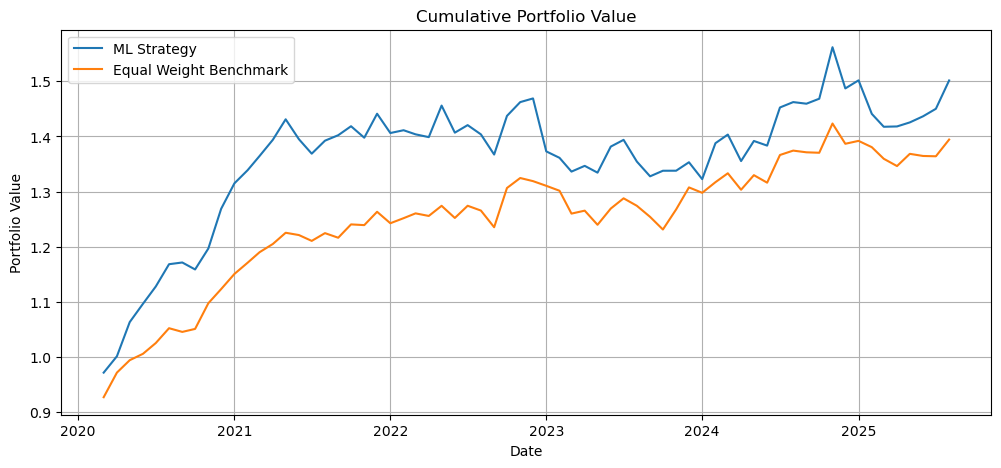

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(df_results.index, df_results["Portfolio_Value_ML"], label="ML Strategy")
plt.plot(df_results.index, df_results["Portfolio_Value_EW"], label="Equal Weight Benchmark")

plt.title("Cumulative Portfolio Value")
plt.ylabel("Portfolio Value")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
class FactorPerformancePredictor:
    """
    Stage 2: Predict factor performance within each market regime using Random Forest
    """
    
    def __init__(self, factor_cols):
        self.factor_cols = factor_cols
        self.regime_models = {}
        self.regime_scalers = {}
        self.feature_cols = ['financial_turbulence', 'nfc_risk', 'nfc_credit', 'nfc_leverage', 'TR CAPE', 'effr', 't3m effr spread', 'sp_3m_drawdown']
        
    def prepare_features(self, full_data, lag_periods=1):
        """Prepare features with lag to avoid data leakage"""
        features_lagged = full_data[self.feature_cols].shift(lag_periods)
        factor_returns = full_data[self.factor_cols]
        aligned_data = pd.concat([features_lagged, factor_returns], axis=1).dropna()
        return aligned_data[self.feature_cols], aligned_data[self.factor_cols]
    
    def create_winning_factor_labels(self, factor_returns):
        """Create binary labels for winning factor each period"""
        winning_factors = factor_returns.idxmax(axis=1)
        labels = {}
        for factor in self.factor_cols:
            labels[factor] = (winning_factors == factor).astype(int)
        return pd.DataFrame(labels, index=factor_returns.index)
    
    def train_regime_specific_models(self, full_data, initial_window=84):
        """Train separate models for each market regime using rolling window approach"""
        features, factor_returns = self.prepare_features(full_data)
        winning_labels = self.create_winning_factor_labels(factor_returns)
        
        # Use TRUE regime for training and combine bear market with correction
        regimes = full_data.loc[features.index, 'True_Regime']
        regimes_combined = regimes.copy()
        regimes_combined[regimes_combined == 2] = 1
        
        all_dates = features.index.sort_values()
        self.rolling_models = {}
        self.rolling_scalers = {}
        
        print(f"Training with {initial_window}-month rolling window...")
        
        for i in range(initial_window, len(all_dates)):
            current_date = all_dates[i]
            train_dates = all_dates[i-initial_window:i]
            
            window_models, window_scalers = self._train_single_window(
                full_data, train_dates, regimes_combined, features, winning_labels
            )
            
            self.rolling_models[current_date] = window_models
            self.rolling_scalers[current_date] = window_scalers
            
            if i % 60 == 0:
                print(f"  Trained up to {current_date.strftime('%Y-%m')}")
        
        return self.rolling_models
    
    def _train_single_window(self, full_data, train_dates, regimes_combined, features, winning_labels):
        """Train models for a single rolling window using Random Forest"""
        window_models = {}
        window_scalers = {}
        
        # Filter data for this window
        window_mask = features.index.isin(train_dates)
        window_features = features[window_mask]
        window_regimes = regimes_combined[window_mask]
        window_labels = winning_labels[window_mask]
        
        # Train models for both regimes (0 and 1)
        for regime in [0, 1]:
            regime_mask = (window_regimes == regime)
            regime_features = window_features[regime_mask]
            regime_labels = window_labels[regime_mask]
            
            if len(regime_features) == 0:
                # Create empty model structure for this regime
                window_models[regime] = {}
                scaler = StandardScaler()
                scaler.fit(features)  # Fit on all features as fallback
                window_scalers[regime] = scaler
                continue
            
            # Scale features
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(regime_features)
            window_scalers[regime] = scaler
            
            regime_models = {}
            
            # Train separate Random Forest for each factor
            for factor in self.factor_cols:
                y = regime_labels[factor]
                
                # Skip if insufficient data
                if len(np.unique(y)) < 2 or len(y) < 10:
                    continue
                
                rf_model = RandomForestClassifier(
                    n_estimators=100, 
                    max_depth=10,
                    random_state=42,
                    class_weight='balanced'
                )
                rf_model.fit(X_scaled, y)
                regime_models[factor] = rf_model
            
            window_models[regime] = regime_models
        
        return window_models, window_scalers
    
    def predict_factor_probabilities(self, full_data):
        """Predict probabilities for each factor using PREDICTED regime"""
        features, _ = self.prepare_features(full_data)
        regimes = full_data.loc[features.index, 'Predicted_Regime']
        regimes_combined = regimes.copy()
        regimes_combined[regimes_combined == 2] = 1
        
        prob_results = pd.DataFrame(index=features.index, columns=self.factor_cols)
        
        print("Predicting factor probabilities...")
        
        for date in features.index:
            if date not in self.rolling_models:
                continue
            
            current_models = self.rolling_models[date]
            current_scalers = self.rolling_scalers[date]
            
            date_features = features.loc[[date]]
            regime = regimes_combined.loc[date]
            
            if regime not in current_models:
                # Use equal weights if no model for this regime
                prob_results.loc[date] = 1.0 / len(self.factor_cols)
                continue
            
            X_scaled = current_scalers[regime].transform(date_features)
            date_probs = {}
            
            # Predict probabilities for each factor
            for factor in self.factor_cols:
                if factor in current_models[regime]:
                    probabilities = current_models[regime][factor].predict_proba(X_scaled)
                    date_probs[factor] = probabilities[0, 1]  # Probability of class 1
                else:
                    date_probs[factor] = 0.0
            
            prob_results.loc[date] = date_probs
        
        # Normalize probabilities
        valid_mask = prob_results.sum(axis=1) > 0
        prob_results = prob_results[valid_mask]
        prob_sums = prob_results.sum(axis=1)
        prob_results = prob_results.div(prob_sums, axis=0)
        
        print(f"Generated probabilities for {len(prob_results)} periods")
        return prob_results

In [18]:
factor_cols = ['Growth', 'Low_Vol', 'Momentum', 'Quality', 'Small_Cap', 'Value']
factor_predictor = FactorPerformancePredictor(factor_cols)

print("start Stage 2 model training...")
rolling_models = factor_predictor.train_regime_specific_models(full_data, initial_window=240)

print("\n start factor prediction ...")
factor_probs = factor_predictor.predict_factor_probabilities(full_data)

start Stage 2 model training...
Training with 240-month rolling window...
  Trained up to 2020-04
  Trained up to 2025-04

 start factor prediction ...
Predicting factor probabilities...
Generated probabilities for 65 periods


In [19]:
factor_probs

,Growth,Low_Vol,Momentum,Quality,Small_Cap,Value
2020-04-01,0.352284,0.010675,0.423535,0.085402,0.064052,0.064052
2020-05-01,0.361345,0.008403,0.386555,0.134454,0.016807,0.092437
2020-06-01,0.443986,0.009586,0.191729,0.239661,0.076692,0.038346
2020-07-01,0.296296,0.123457,0.308642,0.17284,0.061728,0.037037
2020-08-01,0.170213,0.06383,0.478723,0.12766,0.042553,0.117021
...,...,...,...,...,...,...
2025-04-01,0.102804,0.140187,0.233645,0.093458,0.028037,0.401869
2025-05-01,0.137931,0.137931,0.37931,0.183908,0.022989,0.137931
2025-06-01,0.241379,0.16092,0.333333,0.0,0.022989,0.241379
2025-07-01,0.413007,0.247627,0.009298,0.100198,0.0,0.22987


In [20]:
def calculate_factor_accuracy(true_returns, predicted_probs):
    """Calculate accuracy for predicting each factor as winner"""
    common_dates = predicted_probs.index.intersection(true_returns.index)
    
    if len(common_dates) == 0:
        return {}
    
    factor_accuracy = {}
    
    for factor in predicted_probs.columns:
        correct_predictions = 0
        total_predictions = 0
        
        for date in common_dates:
            predicted_winner = predicted_probs.loc[date].idxmax()
            actual_winner = true_returns.loc[date].idxmax()
            
            if predicted_winner == factor:
                total_predictions += 1
                if actual_winner == factor:
                    correct_predictions += 1
        
        if total_predictions > 0:
            accuracy = correct_predictions / total_predictions
        else:
            accuracy = 0
            
        factor_accuracy[factor] = {
            'accuracy': accuracy,
            'predicted_count': total_predictions,
            'correct_count': correct_predictions
        }
    
    return factor_accuracy

def calculate_overall_accuracy(true_returns, predicted_probs):
    """Calculate overall prediction accuracy"""
    common_dates = predicted_probs.index.intersection(true_returns.index)
    correct = 0
    total = 0
    
    for date in common_dates:
        predicted_winner = predicted_probs.loc[date].idxmax()
        actual_winner = true_returns.loc[date].idxmax()
        
        if predicted_winner == actual_winner:
            correct += 1
        total += 1
    
    return correct / total if total > 0 else 0

In [21]:
print(f"\nprediction result:")
print(f"length: {len(factor_probs)}")
print(f"time range: {factor_probs.index.min()} to {factor_probs.index.max()}")


prediction result:
length: 65
time range: 2020-04-01 00:00:00 to 2025-08-01 00:00:00
